Final Project Proposal: <br>
Dataset Description: Data consist all the tweets done by Barak Obama from 2009-2013. Data is in multiple files of JSON format. In future I am planning to get knowledge of Natural Language Processing, so I was looking for some text data. This leads to my data discovery of Tweet Dataset of Barak Obama. I am planning to do sentiment analysis with this Dataset and figure out my hypothesis and question
Dataset Link: https://data.world/socialmediadata/obama-white-house-social-media-obamawhitehouse-tweets/workspace/file?filename=tweets%2F2009_04.js  
Data Structure: It consist of 10 columns
1.	tweet_id	
2.	in_reply_to_status_id	
3.	in_reply_to_user_id	
4.	timestamp	
5.	source	
6.	text	
7.	retweeted_status_id
8.	retweeted_status_user_id	
9.	retweeted_status_timestamp	
10.	expanded_urls
Number of Rows: 27347 rows
Combined Data Size: 9 MB<br>
Hypothesis: Most of Barak Obama's tweets will be regarding healthcare.<br>
Question:  "Which category of emotion is most frequent for Barak Obama's tweet?"


### Overview about the Notebook. 

To answer the question "Which category of emotion is most frequent for Barak Obama?" I've done sentiment Analysis on Barak Obama's Tweet.I've categorised Tweets into 3 catergory as Positive, Negative and Neutral. To categorized the tweets I followed below steps.<BR>
1. Tweet is a Positive Tweet if number of Positive words in a Tweet is greater than number of Negative words.<BR>
2. Tweet is a Negative tweet if Negative words are greater than Positive words. <BR>
3. If number of Positive and negative words are equal in a tweet then its a Neutral Tweet.<BR>
    
To do this I build a vocabulary of Positive and negative word list from Datasets provided below.
1. Positive Words Dataset: https://gist.github.com/mkulakowski2/4289437
2. Negative Words Dataset: https://gist.github.com/mkulakowski2/4289441count 
3. Twitter Sentiment Analysis Dataset: http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/

Results: Positive Tweets are highest with count of 24331.

To identify the Hypothesis: "Most of Barak Obama's tweets will be regarding healthcare". 
I scraped the health related words from "http://www.english-for-students.com/Health-Vocabulary.html" and created healthWordList. And considered a tweet as a healtcare related tweet if atleast one word in a tweet is also is healthWordList.

Results: The Hypothesis is false as only 6768 Tweets out of 27346 overall tweets are related to Health care.

After completing this I checked the accuracy of categorised tweets using Naive Bayes Algorithm. I trained the model with Sentiment Analysis Dataset with different tweets and checked the accuracy of my categorization of tweets.

In [1]:
import time

In [2]:
start_time=time.time()

In [3]:
import json
import os
import fnmatch
import pandas as pd
import re
from nltk.corpus import stopwords
#from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import random
#from sklearn.naive_bayes import MultinomialNB, BernoulliNB
import nltk
import string
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
stop_words=stopwords.words('english')

Reading the first 20,000 rows from the Twitter Sentiment Analysis Dataset. The data set contains two columns first is "Sentiment" containing value 0 and 1 value,0 represents a negative Tweet and 1 represent a Positive Tweet. The other column "SentimentText" contains the Tweets Text.

In [4]:
sentimentData=pd.read_csv('Sentiment Analysis Dataset.csv', usecols=['Sentiment','SentimentText'], nrows=20000)

In [5]:
sentimentData.shape

(20000, 2)

In [6]:
sentimentData.head()

,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...


Lemmatization is the process of converting a word to its base form. We will be Lemmatizing both the tweet dataset and the word lists.<br>
For example: rocks : rock<br>
corpora : corpus<br>
better : good

In [7]:
lemmatizer = WordNetLemmatizer()

Below is the code to fetch the text from json files. These json files contains all Barak Obama's tweets.

In [8]:
text=[]
def fetchText(file_name):
    data = json.load(open(file_name,"r"))
    for item in data:
        text.append([item['text']])

In [9]:
foldr='tweets/'
for file_name in os.listdir(foldr):
    if fnmatch.fnmatch(file_name, '*.js'):
        #print(foldr+file_name)
        fetchText(foldr+file_name)# method call

First five Tweets

In [10]:
text[:5]

[['Welcome to the official Twitter page for the White House!'],
 ['Check out the CDC website (www.cdc.gov) or @CDCemergency to learn more about H1N1 flu (swine flu), as well as prevention tips.'],
 ["RT @CDC_eHealth Check out CDC's new webpage highlighting several new social media tools developed for swine flu. http://is.gd/vfHZ"],
 ["Shooting Around With the Huskies: The President shot a few hoops with the undefeated women's basketball national.. http://tinyurl.com/c2qo7x"],
 ['WhiteHouse 2.0: Today the White House is taking steps to expand how the Administration is communicating with the.. http://tinyurl.com/djh4d5']]

#### The below method takes the input a list of list contating the text. It will clean the text data and return a list of clean data. 

In [11]:
def preprocessText(textList):
    regxUrl="https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|http?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,}"
    punctuation = set(string.punctuation)
    data=pd.DataFrame(textList,columns =['Text'])
    #data['Text']= data['Text'].apply(lambda x: ' '.join([word for word in x.split()]))
    data['Text']= data['Text'].apply(lambda x: ' '.join([word for word in x.split()])) #remove extra space
    data['Text']= data['Text'].apply(lambda x: ' '.join([re.sub(regxUrl, "", word) for word in x.split()])) # Remove URL 
    data['Text']= data['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)])) # remove stop Words
    data['Text']= data['Text'].apply(lambda x: ' '.join([(re.sub('[^a-zA-Z0-9-_.]', '', word)) for word in x.split()])) #remove numbers
    data['Text']= data['Text'].apply(lambda x: ''.join([x.translate(str.maketrans("","", string.punctuation))])) # remove Punctuation marks
    data['Text']= data['Text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])) #Lemmatize words
    data['Text']= data['Text'].apply(lambda x: ' '.join([word.lower() for word in x.split()])) #change the word into lower case
    cleanedTextData=data['Text']
    #print(cleanedTextData)
    return cleanedTextData

We got the clean data in "textData" list

In [12]:
textData=preprocessText(text)

In [13]:
len(textData)

27346

In [14]:
textData[:5]

0            welcome official twitter page white house
1    check cdc website cdcemergency learn h1n1 flu ...
2    rt cdcehealth check cdcs new webpage highlight...
3    shooting around with huskies the president sho...
4    whitehouse 20 today white house taking step ex...
Name: Text, dtype: object

Reading the data from positive-words.txt and negative-words.txt and creating positiveWordList, negativeWordList.

In [15]:
with open('positive-words.txt','r') as p: # Opening the file
    positiveWordList=p.readlines()
with open('negative-words.txt','r') as n: # Opening the file
    negativeWordList=n.readlines()

In [16]:
positiveWordList=positiveWordList[36:]
negativeWordList=negativeWordList[35:]

Lemmatizing each word from the list.

In [17]:
positiveWordList= [lemmatizer.lemmatize(word) for word in positiveWordList]
negativeWordList= [lemmatizer.lemmatize(word) for word in negativeWordList]

The below method remove the repetative words from a list.

In [18]:
def removeRepeatWord(wordList):
    newList=[]
    for word in wordList:
        if word not in newList:
            newList.append(word)
    return newList

Currenlty we have very less words in our positive and negative word list. To build our vocabulary we will fetch more words from the sentimentData dataset. We have the labled data as positive and negative in sentimentData dataset. We will fetch words from positive tweets and negative tweets then append it to positiveWordList and negativeWordList respectively.

In [19]:
print(len(positiveWordList))
print(len(negativeWordList))

2005
4783


From the sentimentData dataset creating the list of positive and negative tweets

In [20]:
positiveTweets=(sentimentData[sentimentData['Sentiment']==1]['SentimentText'].reset_index().drop(columns=['index'])).values.tolist()
negativeTweets=(sentimentData[sentimentData['Sentiment']==0]['SentimentText'].reset_index().drop(columns=['index'])).values.tolist()

Cleaning the data

In [21]:
positiveTweets=preprocessText(positiveTweets)
negativeTweets=preprocessText(negativeTweets)

In [22]:
print(len(positiveTweets))
print(len(negativeTweets))

9297
10703


The below code pick out the adjective, adverb and verb words from the positiveTweets and negativeTweets and append it to positiveWordList and negativeWordList respectively.

In [23]:
allowed_word_types = ["J","R","V"] # J is adjective, R is adverb, and V is verb
for tweet in positiveTweets:
    words = word_tokenize(tweet)
    #print(words)
    pos = nltk.pos_tag(words) # nltk.pos_tag (part of speech tag) method tag each word with its part of speech. It will help us to identify adjective, adverb, and verbs
    for w in pos:
        if w[1][0] in allowed_word_types:
            #print(w[1][0])
            if (w[0].lower()) not in positiveWordList:
                positiveWordList.append(w[0].lower())
                #poswords.append(w[0].lower())

In [24]:
for tweet in negativeTweets:
    words = word_tokenize(tweet)
    pos = nltk.pos_tag(words)
    for w in pos:
        if w[1][0] in allowed_word_types:
            if (w[0].lower()) not in positiveWordList:
                negativeWordList.append(w[0].lower())
                #negwords.append(w[0].lower())

In [25]:
print(len(positiveWordList))
print(len(negativeWordList))

10564
11119


There might be some common words in both the list. So removing common words from both the list

In [26]:
#repeat=[]
for word in positiveWordList:
    if word in negativeWordList:
        positiveWordList.remove(word)
        negativeWordList.remove(word)
        #repeat.append(word)

In [27]:
print(len(positiveWordList))
print(len(negativeWordList))

10562
11117


There are chances too have stop words in the positive and negative word list so removing it.

In [28]:
positiveWordList = [w for w in positiveWordList if w not in stop_words]
negativeWordList = [w for w in negativeWordList if w not in stop_words]

In [29]:
print(len(positiveWordList))
print(len(negativeWordList))

10509
11112


The below method will find the Synonym of the list of words. This will build our vocabulary.

In [30]:
Synonym=[]
def findSynonym(wordList):
    synonymList=[]
    for word in wordList:
        for syn in wordnet.synsets(word):#wordnet.sysnsets() find the synonyms
            synonymList.append(syn.lemmas()[0].name()) #converting the synonyms to its lemmas
    return synonymList

Finding synonyms of positive and negative word list

In [31]:
positiveSynonymList= findSynonym(positiveWordList)
negativeSynonymList= findSynonym(negativeWordList)

In [32]:
print(len(positiveSynonymList))
print(len(negativeSynonymList))

26269
14161


Appending the synonym lists to postive and negative word list. And checking for duplicate words

In [33]:
for syn in positiveSynonymList:
    if syn not in positiveWordList:
        positiveWordList.append(syn)
for syn in negativeSynonymList:
    if syn not in negativeWordList:
        negativeWordList.append(syn)

In [34]:
print(len(positiveWordList))
print(len(negativeWordList))

14834
13863


Again removing repetative words from the list

In [35]:
positiveWordList = removeRepeatWord(positiveWordList)
negativeWordList = removeRepeatWord(negativeWordList)

In [36]:
print(len(positiveWordList))
print(len(negativeWordList))

14834
12568


Again removing the stopwords from the list if any.

In [37]:
positiveWordList = [w for w in positiveWordList if w not in stop_words]
negativeWordList = [w for w in negativeWordList if w not in stop_words]

In [38]:
print(len(positiveWordList))
print(len(negativeWordList))

14812
12557


Removing the common words in the both the list

In [39]:
repeat=[]
for word in positiveWordList:
    if word in negativeWordList:
        positiveWordList.remove(word)
        negativeWordList.remove(word)
        repeat.append(word)

Finally we have 13365 postive words and 11110 negative words

In [40]:
print(len(positiveWordList))
print(len(negativeWordList))

13365
11110


To indentify our Hypothesis I scraped the data from the below url using BeautifulSoup

In [41]:
response = requests.get("http://www.english-for-students.com/Health-Vocabulary.html")
response.ok

True

In [42]:
soup = BeautifulSoup(response.text, 'html.parser')
#print(soup.prettify())
every_li = soup.findAll('li') #all the words are in "li" tag
healthWordList=[]
for elem in every_li:
    healthWordList.append(elem.text.strip())
healthWordList=healthWordList[31:348] # the word list starts from 31, before that there is some text data
healthWordList[1]='Abstinence'
healthWordList[14]='Anxiety'

Adding Synonms to healthWordList

In [43]:
healthSynonymList= findSynonym(healthWordList)
for syn in healthSynonymList:
    if syn not in healthWordList:
        healthWordList.append(syn)

In [44]:
len(healthWordList)

1071

In [45]:
len(textData)

27346

The below code catergorise each tweet in textData as Positive, Negative and Neutral. And store them in list name positiveTweets, negativeTweets and neutralTweets respectively.
Also identify the healthcare tweets and store them in list name healthTweets.

In [46]:
positiveTweets=[]
negativeTweets=[]
neutralTweets=[]
healthTweets=[]

In [47]:
for tweet in textData:
    positiveCount=0
    negativeCount=0
    healthCount=0
    words=word_tokenize(tweet)# word tokenize the tweet.
    for w in words:
        if w in positiveWordList:
            positiveCount+=1 # increasing the positiveCount by one if word found in positiveWordList
            #print('positive word : ' + w)
        if w in negativeWordList:
            negativeCount+=1 # increasing the negativeCount by one if word found in negativeWordList
            #print('Negative word : ' + w)
    #print(positiveCount,negativeCount)
        if w in healthWordList:
            healthCount+=1 # increasing the healthCount by one if word found in healthWordList
    if(positiveCount>negativeCount): #if positive count is greater then appending the tweet in positiveTweets
        #print(tweet+' is positive')
        #positiveTweetsCount+=1
        positiveTweets.append(tweet)
    elif(negativeCount>positiveCount): #if negative count is greater then appending the tweet in negativeTweets
        #negativeTweetsCount+=1
        negativeTweets.append(tweet)
        #print(tweet+' is negative')
    else:
        #neutralTweetsCount+=1 
        neutralTweets.append(tweet) #else considering the tweet as neutral
    if healthCount>=1: # if atleat one word in the tweet matches to the healthWordList
        healthTweets.append(tweet) # appending it to healthTweets

In [48]:
print("Total Number of Positive Tweets: " + str(len(positiveTweets)))
print("Total Number of Negative Tweets: " + str(len(negativeTweets)))
print("Total Number of Neutral Tweets: " + str(len(neutralTweets)))
print("Total Number of Health Care Related Tweets: " + str(len(healthTweets)))

Total Number of Positive Tweets: 24331
Total Number of Negative Tweets: 1058
Total Number of Neutral Tweets: 1957
Total Number of Health Care Related Tweets: 16238


Plotting the bar plot to show the difference.

In [49]:
TeweetCount=[len(positiveTweets),len(negativeTweets),len(neutralTweets)]
Sentiments=['Positive', 'Nagative', 'Neutral']

## Question: "Which category of emotion is most frequent for Barak Obama's tweet?"
## Answer: Positive Emotion

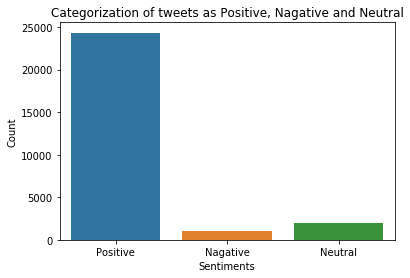

In [50]:
f, ax = plt.subplots()
sns.barplot(x=Sentiments,y=TeweetCount)
plt.xlabel('Sentiments')
plt.ylabel('Count')
#plt.xticks(rotation='vertical')
plt.title('Categorization of tweets as Positive, Nagative and Neutral')
plt.show()

Comparing all tweets with number of health care tweets

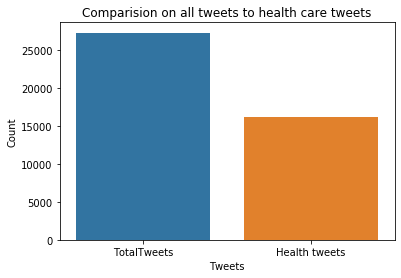

In [51]:
f, ax = plt.subplots()
tweets=['TotalTweets','Health tweets']
tweet=[len(textData),len(healthTweets)]
sns.barplot(x=tweets,y=tweet) 
plt.xlabel('Tweets')
plt.ylabel('Count')
#plt.xticks(rotation='vertical')
plt.title('Comparision on all tweets to health care tweets')
plt.show()

## Hypothesis: Most of Barak Obama's tweets will be regarding healthcare.
## Answer: No, most of the tweets are not related to healthcare.

Creating wordcloud to show the most frequent words. Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance.

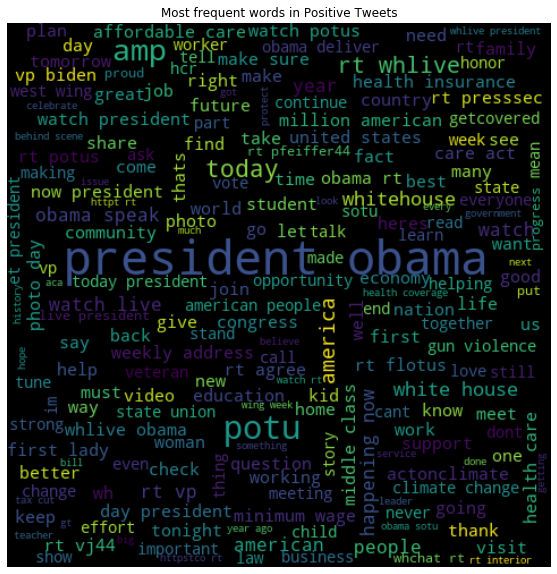

In [52]:
wordcloud = WordCloud(width=480, height=480, margin=0).generate(' '.join(positiveTweets))
 
# Display the generated image:
plt.figure( figsize=(10,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Most frequent words in Positive Tweets")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


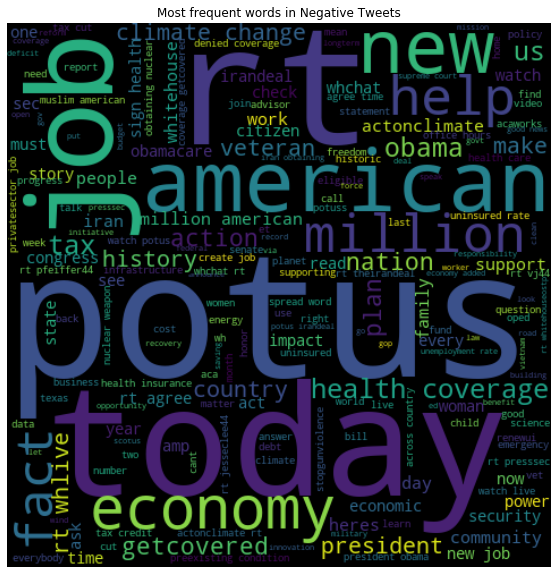

In [53]:
wordcloud = WordCloud(width=480, height=480, margin=0).generate(' '.join(negativeTweets))
 
# Display the generated image:
plt.figure( figsize=(10,10) )
plt.imshow(wordcloud, interpolation='bilinear')
#plt.figsize=(10, 10)
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Most frequent words in Negative Tweets")
plt.show()


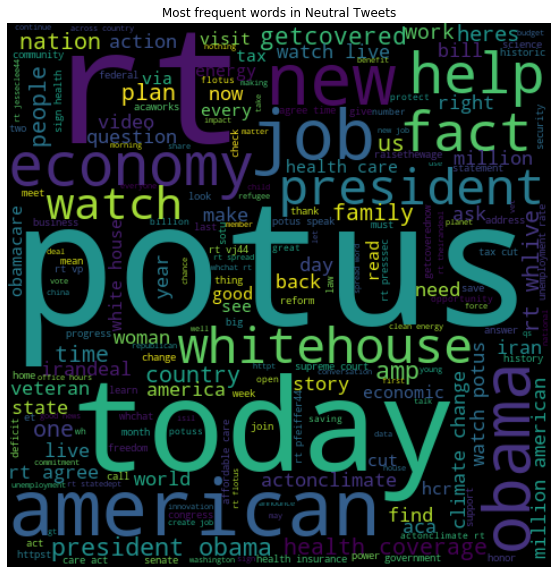

In [54]:
wordcloud = WordCloud(width=480, height=480, margin=0).generate(' '.join(neutralTweets))
 
# Display the generated image:
plt.figure( figsize=(10,10) )
plt.imshow(wordcloud, interpolation='bilinear')
#plt.figsize=(10, 10)
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Most frequent words in Neutral Tweets")
plt.show()

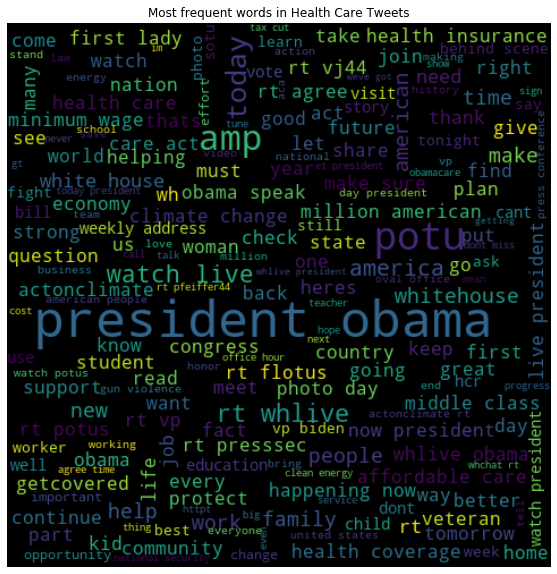

In [55]:
wordcloud = WordCloud(width=480, height=480, margin=0).generate(' '.join(healthTweets))
 
# Display the generated image:
plt.figure( figsize=(10,10) )
plt.imshow(wordcloud, interpolation='bilinear')
#plt.figsize=(10, 10)
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Most frequent words in Health Care Tweets")
plt.show()

### Learning from this project: <br>1. I got exposure to work with Text data and clean it. <br>2.  Further I learned a lot about the nltk library and its functions.<br> 3. Working with JSON files <br> 4. Data Scraping

In [56]:
timee=round(time.time() - start_time,2)
print('elapsed time:',round(time.time() - start_time,2))

elapsed time: 467.76


Now lets check how accurate is our categorization of Positive, Negative and Neutral Tweets. For this we will be using Naive Bayes algorithm. I will train the model with our sentimentData dataset (We will not use those tweets we used for categorizing). Then we will check the accurecy for the our testing set.

In [57]:
sentimentData=pd.read_csv('Sentiment Analysis Dataset.csv', usecols=['Sentiment','SentimentText'], nrows=40000)

In [58]:
sentimentData.head()

,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...


Picking out Positive and Negative Tweets from sentimentData data set.

In [59]:
trainPositiveTweets=(sentimentData[sentimentData['Sentiment']==1]['SentimentText'].reset_index().drop(columns=['index'])).values.tolist()
trainNegativeTweets=(sentimentData[sentimentData['Sentiment']==0]['SentimentText'].reset_index().drop(columns=['index'])).values.tolist()

In [60]:
print(len(trainPositiveTweets))
print(len(trainNegativeTweets))

20952
19048


Cleaning the Data

In [61]:
trainPositiveTweets=preprocessText(trainPositiveTweets[20000:])
trainNegativeTweets=preprocessText(trainNegativeTweets[18000:])

This function will return the featureset that will be used as training and testing sets for our model

In [62]:
def returnFeatureSet(positiveTextList, negativeTextList):
    doc=[]
    all_words = []
    for r in positiveTextList:
        doc.append((r,"pos"))
    for r in negativeTextList:
        doc.append((r,"neg"))
        
    short_pos_words = word_tokenize(' '.join(positiveTextList))
    short_neg_words = word_tokenize(' '.join(negativeTextList))
    
    for w in short_pos_words:
        all_words.append(w.lower())

    for w in short_neg_words:
        all_words.append(w.lower())
    
    all_words = nltk.FreqDist(all_words)
    word_features = list(all_words.keys())
    
    def find_features(documents):
        words = word_tokenize(documents)
        features = {}
        for w in word_features:
            features[w] = (w in words)
        #print(features)
        return features

    featuresets = [(find_features(rev), category) for (rev, category) in doc]
    random.shuffle(featuresets)
    
    return featuresets
    

In [63]:
trainFeatureSet = returnFeatureSet(trainPositiveTweets, trainNegativeTweets)

We will train our training Feature Set using Naive Bays Classifier

In [64]:
classifier = nltk.NaiveBayesClassifier.train(trainFeatureSet)

In [66]:
testFeatureSet = returnFeatureSet(positiveTweets[:5000], negativeTweets[:5000])

Cheking the accuracy of our testing set

In [67]:
print("Original Naive Bayes Algo accuracy percent:", (nltk.classify.accuracy(classifier, testFeatureSet))*100)

Original Naive Bayes Algo accuracy percent: 48.25024760647078


In [69]:
print('elapsed time:',round(time.time() - timee,2))

elapsed time: 1576697199.26
